In [1]:
print("hello")

hello


In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")

In [3]:
model_name = "deepseek-r1-distill-llama-70b"

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model=model_name, api_key=GROQ_API_KEY)
llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 4, 'total_tokens': 18, 'completion_time': 0.071092337, 'prompt_time': 9.1129e-05, 'queue_time': 0.056855410999999995, 'total_time': 0.071183466}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--8a9c0a9c-2a5d-40a4-b54d-468038e9a683-0', usage_metadata={'input_tokens': 4, 'output_tokens': 14, 'total_tokens': 18})

In [5]:
# we are using deepseek, which is a reasoning model 
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [9]:
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END


In [7]:
def call_model(state: HumanMessage):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages" : response}

# Design a workflow with binding tool calls 

In [27]:
@tool
def search(query: str):
    """get weather report tool"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

In [12]:
search.invoke("what is a tempurature in kashmir?")

'the temp is 25 degree and cloudy'

In [13]:

search

StructuredTool(name='search', description='get weather report tool', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10b32d300>)

In [14]:
# this search is of custom tool of type StructuredTool

In [15]:
llm.invoke("what is a weather in delhi?")


AIMessage(content='<think>\n\n</think>\n\nAs of my last update in July 2024, I cannot provide real-time weather information. However, Delhi generally experiences a humid subtropical climate with extreme summer and winter seasons. Summers are very hot, with temperatures often reaching 45°C (113°F) or more, while winters can be quite cold, with temperatures dropping to around 2-5°C (36-41°F). The monsoon season typically occurs between July and September, bringing significant rainfall. For the most current weather information, I recommend checking a reliable weather service or app.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 11, 'total_tokens': 126, 'completion_time': 0.418181818, 'prompt_time': 0.000287276, 'queue_time': 0.052630083999999994, 'total_time': 0.418469094}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--70b6ea18-dab7-4ded-85f8

## Binding the tool to the LLM 

In [28]:
tools = [search]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
response = llm_with_tools.invoke("what is the weather in delhi ?")
print(response.content)

content='' additional_kwargs={'tool_calls': [{'id': 'zjp3kg282', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 231, 'prompt_tokens': 128, 'total_tokens': 359, 'completion_time': 0.928713346, 'prompt_time': 0.008214311, 'queue_time': 0.052300009, 'total_time': 0.936927657}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1ef8289a-587d-45f1-9ed2-8d5a3b0689e5-0' tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'zjp3kg282', 'type': 'tool_call'}] usage_metadata={'input_tokens': 128, 'output_tokens': 231, 'total_tokens': 359}


In [19]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
from langchain_google_genai import GoogleGenerativeAI
gemini_llm = GoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    google_api_key=GEMINI_API_KEY,
    max_output_tokens=1024,)
response = gemini_llm.invoke("hello gemini")
print(response)


Hello there! How can I help you today?


In [20]:
from langchain.chat_models import init_chat_model
gemini_llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",  google_api_key=GEMINI_API_KEY)

In [24]:
gemini_llm_with_tools = gemini_llm.bind_tools(tools)
response = gemini_llm_with_tools.invoke("what is the weather in delhi")


In [25]:
response.content

''

In [29]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

In [30]:
input={"messages":["what is a weather in delhi?"]}

In [31]:
response=call_model(input)

In [32]:
response["messages"][-1].content

''

In [33]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'mv0nkk632',
  'type': 'tool_call'}]

In [34]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (mv0nkk632)
 Call ID: mv0nkk632
  Args:
    query: weather in Delhi


# Creating a langggraph workflow with binding llm with different tools 

In [74]:
def router(state: MessagesState):
    print("----- router ------")

    # route the query for llm call with tools or 
    message = state["messages"][-1]

    if message.tool_calls:
        return "tools"
    
    return END

In [ ]:
@tool
def weather(state: MessagesState):
    """get weather report tool"""
    query = state["messages"][-1]
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"
    
        

In [76]:
@tool
def finance(state : MessagesState):
    """ get finance report """
    query = state["messages"][-1]

    if "gdp" in query.lower():
        return "The GDP of India is around 3 Trillion dollars"
    
    return "Business news as normal"

In [77]:
@tool
def science(state : MessagesState):
    """ get science report """
    query = state["messages"][-1]

    if "colbert" in query.lower():
        return "Late Intercation is being used"
    
    return "Gneral Retrieval techniques"

In [78]:
tools = [weather, finance, science]

In [79]:
tools

[StructuredTool(name='weather', description='get weather report tool', args_schema=<class 'langchain_core.utils.pydantic.weather'>, func=<function weather at 0x110294fe0>),
 StructuredTool(name='finance', description='get finance report', args_schema=<class 'langchain_core.utils.pydantic.finance'>, func=<function finance at 0x110267380>),
 StructuredTool(name='science', description='get science report', args_schema=<class 'langchain_core.utils.pydantic.science'>, func=<function science at 0x110267060>)]

In [103]:
def call_model(state: MessagesState):
    message = state["messages"]
    print("--- calling LLM ---")
    print(message)

    prompt = """
      You are provided with different tools integrated within yourself
"""
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(message)
    print("response")
    return {"messages": [response]}

In [90]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'weather': StructuredTool(name='weather', description='get weather report tool', args_schema=<class 'langchain_core.utils.pydantic.weather'>, func=<function weather at 0x110294fe0>), 'finance': StructuredTool(name='finance', description='get finance report', args_schema=<class 'langchain_core.utils.pydantic.finance'>, func=<function finance at 0x110267380>), 'science': StructuredTool(name='science', description='get science report', args_schema=<class 'langchain_core.utils.pydantic.science'>, func=<function science at 0x110267060>)}, tool_to_state_args={'weather': {}, 'finance': {}, 'science': {}}, tool_to_store_arg={'weather': None, 'finance': None, 'science': None}, handle_tool_errors=True, messages_key='messages')

In [98]:
workflow = StateGraph(MessagesState)

In [99]:
workflow.add_node("llmwithtool", call_model)
# Binded with all the tools 
# workflow.add_node("mytools", tool_node)

# we are having a toolnode instead of separately tools, beter keep a toolnode instead of eachsingle tools
workflow.add_node("mytools", tool_node)

workflow.add_edge(START, "llmwithtool")
workflow.add_edge("mytools", END)
workflow.add_edge("mytools", "llmwithtool" )

workflow.add_conditional_edges("llmwithtool", router, {
    "tools": "mytools",
    END : END
})
workflow.set_entry_point("llmwithtool")
# workflow.set_finish_point(END)

In [100]:
app2=workflow.compile()


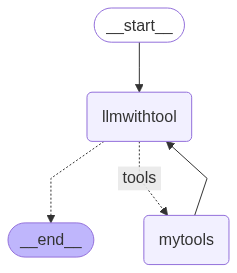

In [101]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [105]:
response=app2.invoke({"messages":["what is a weather in bengraluru?"]})



--- calling LLM ---
[HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='568db8c5-7387-4cc3-a311-3e520cdf7558')]


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool_call>{"name": "weather", "arguments": {"city": "Bangalore"}}</tool_call>'}}